In [ ]:
# Import Required Libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import scipy
import sklearn
import os
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
#  Load EEG Data
data_folder = r"D:\dataset eeg"

# Get all .npz files in the folder
npz_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]

# Load all .npz files into a dictionary
eeg_data = {}
for file in npz_files:
    file_path = os.path.join(data_folder, file)
    data = np.load(file_path, allow_pickle=True)
    eeg_data[file] = data

# Print keys of the first file
first_file = npz_files[0]
print(f"Keys in {first_file}: {list(eeg_data[first_file].keys())}")


Keys in eeg-predictive_train.npz: ['train_signals', 'train_labels']


In [ ]:
#  Merge Training Data
train_signals_1 = eeg_data["eeg-predictive_train.npz"]["train_signals"]
train_labels_1 = eeg_data["eeg-predictive_train.npz"]["train_labels"]

train_signals_2 = eeg_data["eeg-seizure_train.npz"]["train_signals"]
train_labels_2 = eeg_data["eeg-seizure_train.npz"]["train_labels"]

# Merge the datasets
train_signals = np.concatenate((train_signals_1, train_signals_2), axis=0)
train_labels = np.concatenate((train_labels_1, train_labels_2), axis=0)

# Print shape of merged data
print("Merged Train Signals Shape:", train_signals.shape)
print("Merged Train Labels Shape:", train_labels.shape)


Merged Train Signals Shape: (45948, 23, 256)
Merged Train Labels Shape: (45948,)


In [4]:
# Find indices of seizure (1) and non-seizure (0) samples
seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]

# Randomly select 5,000 samples from each class
np.random.seed(42)  # For reproducibility
seizure_sample = np.random.choice(seizure_indices, 8000, replace=False)
non_seizure_sample = np.random.choice(non_seizure_indices, 8000, replace=False)

# Combine selected samples
selected_indices = np.concatenate((seizure_sample, non_seizure_sample))

# Subset the dataset
train_signals_balanced = train_signals[selected_indices]
train_labels_balanced = train_labels[selected_indices]

# Print new dataset size
print("Balanced Train Signals Shape:", train_signals_balanced.shape)
print("Balanced Train Labels Shape:", train_labels_balanced.shape)

# Check label distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("New Label Distribution:", dict(zip(unique, counts)))

Balanced Train Signals Shape: (16000, 23, 256)
Balanced Train Labels Shape: (16000,)
New Label Distribution: {0.0: 8000, 1.0: 8000}


In [ ]:
import numpy as np
import scipy.fftpack


mav = np.mean(np.abs(train_signals_balanced), axis=(1, 2))

#  Apply Fast Fourier Transform (FFT) to get frequency-domain features
fft_features = np.abs(scipy.fftpack.fft(train_signals_balanced, axis=-1))

# Extract low-frequency power (0–15Hz roughly corresponds to first ~15 bins)
low_freq_power = np.sum(fft_features[:, :, :15], axis=(1, 2))

# Step 3: Define thresholds
mav_severe_thresh = np.percentile(mav, 90)    # Top 10% MAV → Severe
mav_mild_thresh = np.percentile(mav, 50)      # 50–90% MAV → Mild

low_freq_high_thresh = np.percentile(low_freq_power, 80)  # High seizure pattern

# Step 4: Create new labels using hybrid logic
new_labels = []
for i in range(len(mav)):
    if mav[i] >= mav_severe_thresh or low_freq_power[i] >= low_freq_high_thresh:
        new_labels.append(1)  # Severe Epileptic
    elif mav[i] >= mav_mild_thresh:
        new_labels.append(2)  # Mild Epileptic
    else:
        new_labels.append(0)  # Non-Epileptic

train_labels_balanced = np.array(new_labels)

# Step 5: Print updated label distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("Label Distribution:", dict(zip(unique, counts)))


Label Distribution: {0: 8000, 1: 3319, 2: 4681}


In [6]:
# Normalize EEG signals (Min-Max Scaling)
train_signals_balanced = (train_signals_balanced - np.min(train_signals_balanced)) / (np.max(train_signals_balanced) - np.min(train_signals_balanced))

print("EEG Signals After Normalization:")
print("Min:", np.min(train_signals_balanced), "Max:", np.max(train_signals_balanced))

EEG Signals After Normalization:
Min: 0.0 Max: 1.0


In [7]:
# Bandpass filter function (removes noise outside 0.5–40 Hz)
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

# Apply bandpass filter to EEG signals
train_signals_filtered = bandpass_filter(train_signals_balanced)

print("EEG Signals After Bandpass Filtering:")
print("Shape:", train_signals_filtered.shape)

EEG Signals After Bandpass Filtering:
Shape: (16000, 23, 256)


In [8]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
train_labels_onehot = to_categorical(train_labels_balanced, num_classes=3)

# Print first 5 samples to check encoding
print("Example of One-Hot Encoded Labels:")
print(train_labels_onehot[:5])

Example of One-Hot Encoded Labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


Feature Extraction Step - Input Shape for Model: (16000, 256, 23)


Model: "functional_4"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 256, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_feature_ext… │ (None, 256, 128)  │     45,056 │ input_sequence[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 256, 128)  │          0 │ bilstm_feature_e… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512

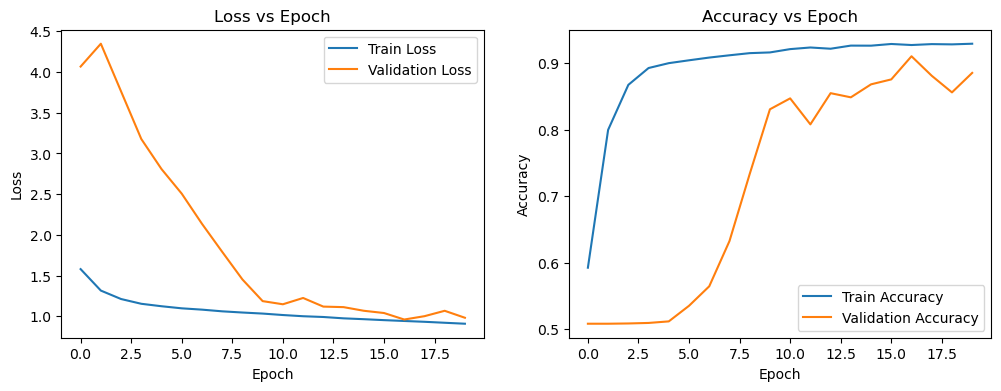

In [ ]:
#2 fe-lstm mt-transformer

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, Add, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re



#feature extraction using lstm
X = np.transpose(train_signals_filtered, (0, 2, 1))  # (num_samples, 256, 23)
print("Feature Extraction Step - Input Shape for Model:", X.shape)

# transformer model 
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.5):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x_ff = Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1], kernel_regularizer=tf.keras.regularizers.l2(0.002))(x_ff)
    
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    return x

#the enhanced model for ete 
input_seq = Input(shape=(256, 23), name="input_sequence")

#=LSTM
x = tf.keras.layers.Bidirectional(
    LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    name="bilstm_feature_extractor"
)(input_seq)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

#  Two Transformer Blocks
for i in range(2):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=64, dropout=0.3)

# Global Average Pooling
x = GlobalAveragePooling1D(name="global_avg_pool")(x)

# Dense classifier
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax', name="classification_output")(x)

model = Model(inputs=input_seq, outputs=output)

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=loss_fn,
    metrics=['accuracy']
)


plain_model_summary(model)


#  Training the Model

X_train, X_test, y_train, y_test = train_test_split(
    X, train_labels_onehot, test_size=0.2, random_state=42, stratify=train_labels_balanced
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop, reduce_lr]
)



# Evaluating  Model

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')

plt.show()



100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.9111    0.9800    0.9443      1600
           1     0.9628    0.8569    0.9068       664
           2     0.8570    0.8130    0.8344       936

    accuracy                         0.9056      3200
   macro avg     0.9103    0.8833    0.8952      3200
weighted avg     0.9060    0.9056    0.9044      3200



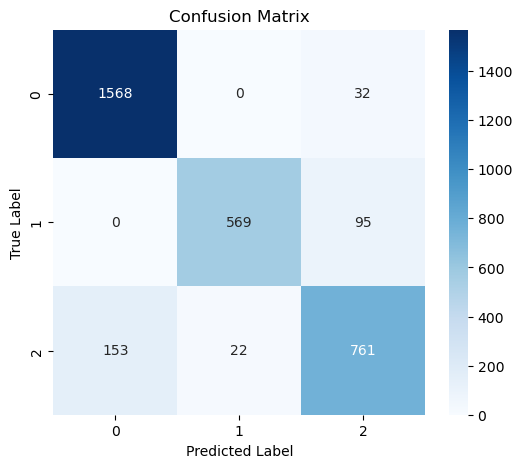

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # True labels

# Compute F1 Score
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


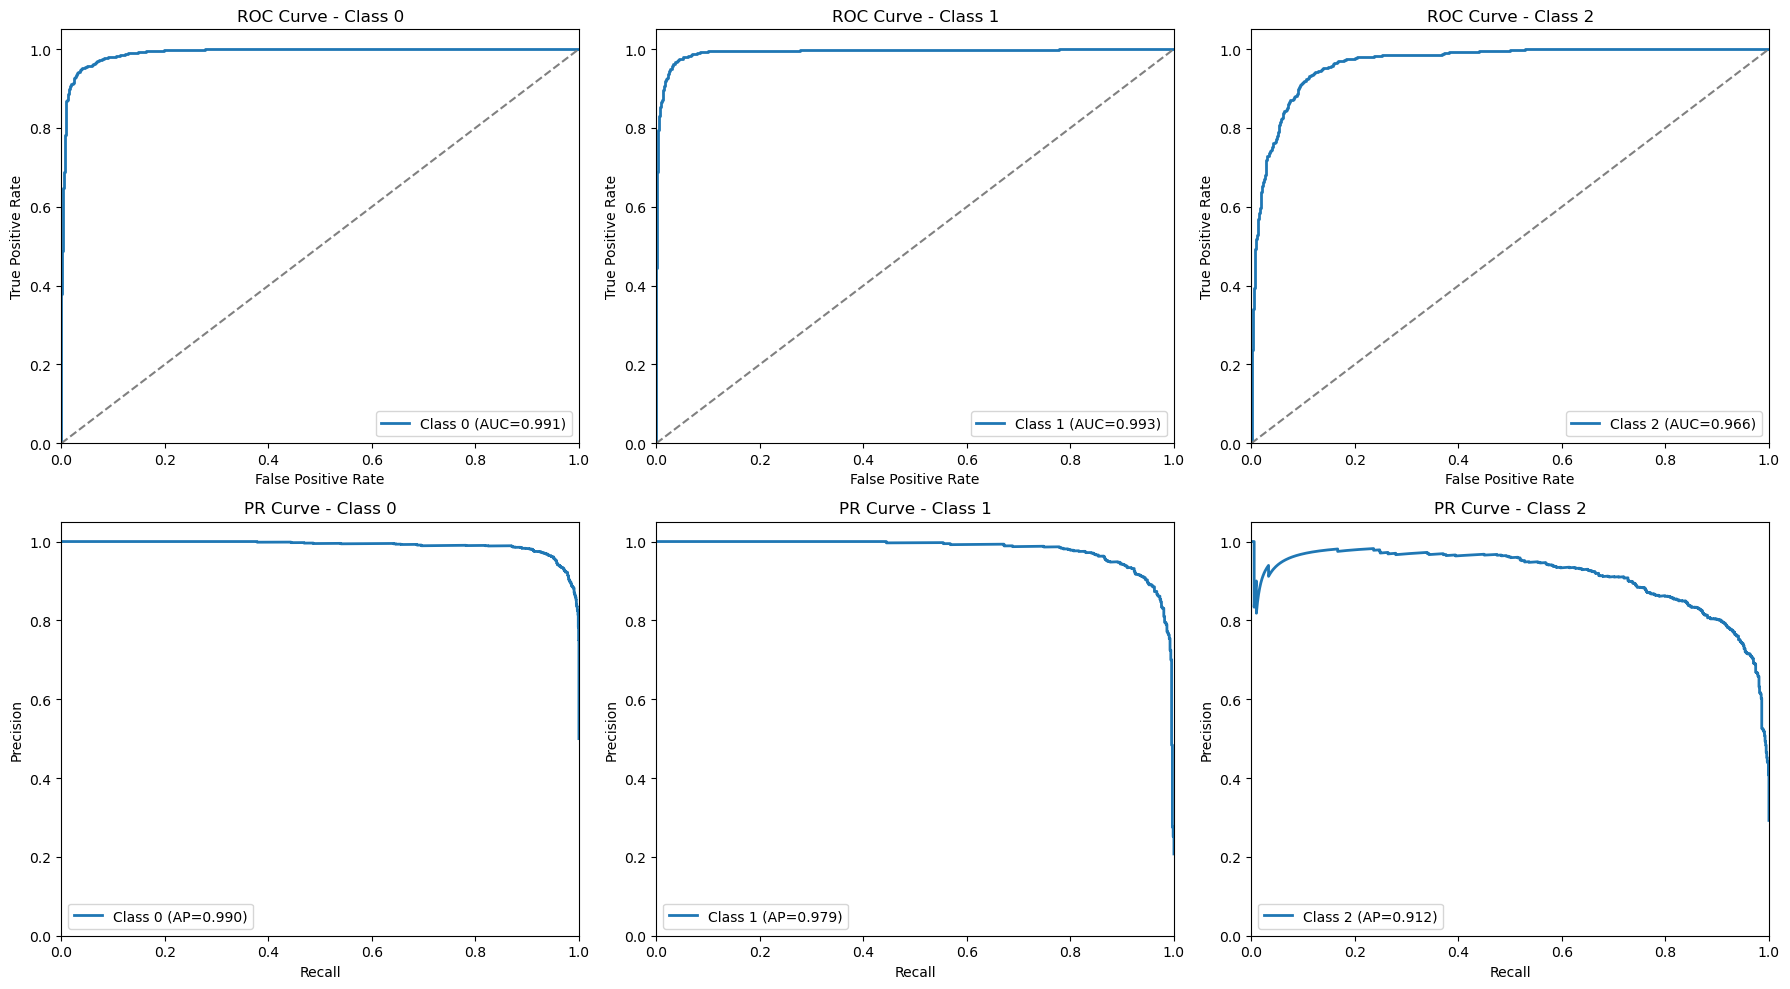

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Assuming your y_true is 1D class labels and y_pred_probs is softmax output
n_classes = y_pred_probs.shape[1]
y_true_onehot = label_binarize(y_true, classes=np.arange(n_classes))

# Create subplots
fig, axes = plt.subplots(2, n_classes, figsize=(18, 10))

roc_auc_scores = []
ap_scores = []

for i in range(n_classes):
    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    # PR and AP
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true_onehot[:, i], y_pred_probs[:, i])
    ap_scores.append(ap)

    # Plot ROC
    axes[0, i].plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.3f})')
    axes[0, i].plot([0, 1], [0, 1], color="gray", linestyle="--")
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - Class {i}')
    axes[0, i].legend(loc="lower right")

    # Plot PR
    axes[1, i].plot(recall, precision, lw=2, label=f'Class {i} (AP={ap:.3f})')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'PR Curve - Class {i}')
    axes[1, i].legend(loc="lower left")

plt.tight_layout()
plt.show()
